In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8

# Install Spark NLP Display lib
! pip install --upgrade -q spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00


In [ ]:
!pip install onnxruntime yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.4 MB/s eta 0:00:00


In [ ]:
import json
import datetime
import sparknlp
import pyspark.sql.functions as F
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

In [ ]:
df = yf.download("GOOGL", start="2015-01-01", end="2023-05-02",)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000


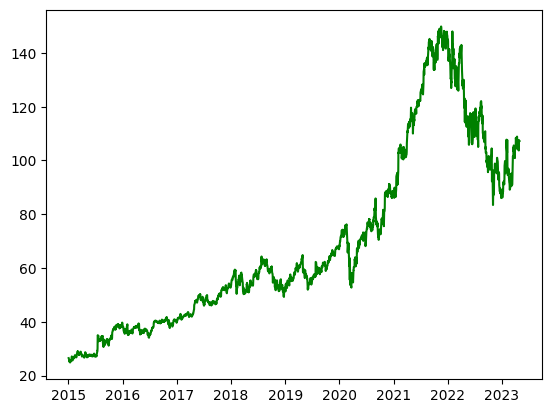

In [ ]:
plt.plot(df.index, df["Close"], color = "green", label="Close")
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])

dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))
training_data_len

1677

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
feature_length = 100

train_data = scaled_data[0:training_data_len, :]

def Create_Features_target(data,feature_length):
  X = list()
  Y = list()
  for i in range(len(data)-feature_length-1):
    X.append(data[i:(i+feature_length),0])
    Y.append(data[i+feature_length,0])
  X = np.array(X)
  Y = np.array(Y)
  return X,Y

X_train,y_train = Create_Features_target(train_data,feature_length)

In [ ]:
#Model
model1 = Sequential([
    LSTM(100, return_sequences=True, input_shape = (X_train.shape[1],1)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),

    Dense(1),
])
model1.compile(optimizer = "adam", loss = "mean_squared_error")
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12
  )

Epoch 1/100
132/132 [==============================] - 11s 16ms/step - loss: 0.0035
Epoch 2/100
132/132 [==============================] - 2s 17ms/step - loss: 0.0014
Epoch 3/100
132/132 [==============================] - 2s 12ms/step - loss: 0.0017
Epoch 4/100
132/132 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 5/100
132/132 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 6/100
132/132 [==============================] - 2s 12ms/step - loss: 9.3221e-04
Epoch 7/100
132/132 [==============================] - 1s 11ms/step - loss: 9.1996e-04
Epoch 8/100
132/132 [==============================] - 2s 12ms/step - loss: 9.1064e-04
Epoch 9/100
132/132 [==============================] - 2s 14ms/step - loss: 7.6739e-04
Epoch 10/100
132/132 [==============================] - 2s 16ms/step - loss: 7.4467e-04
Epoch 11/100
132/132 [==============================] - 2s 13ms/step - loss: 7.2776e-04
Epoch 12/100
132/132 [==============================] - 1s 1

In [ ]:

# Create the testing data set
test_data = scaled_data[training_data_len - feature_length: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(feature_length, len(test_data)):
    x_test.append(test_data[i-feature_length:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model1.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
error = mean_absolute_percentage_error(y_test, predictions)
print(error)


14/14 [==============================] - 1s 7ms/step
3.17274116242143
0.021540425289099777


<ipython-input-13-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


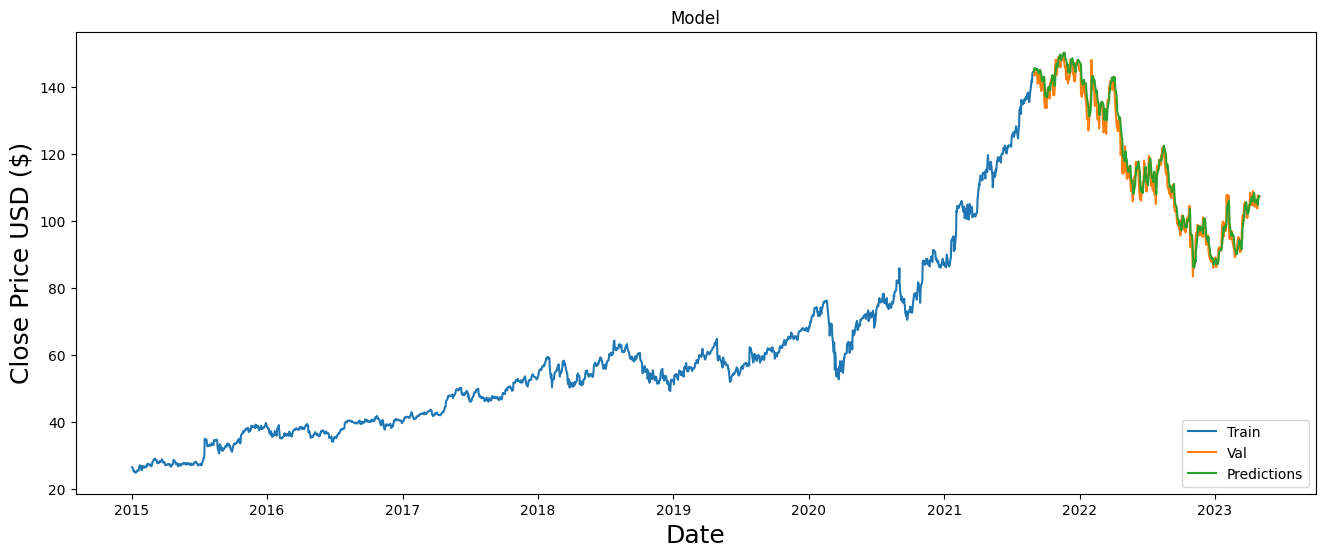

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,Close,Predictions
Date,,
2021-08-31,144.697495,144.522552
2021-09-01,145.215500,145.088303
2021-09-02,143.287003,145.623383
2021-09-03,143.739502,145.100098
2021-09-07,144.280502,145.062424
...,...,...
2023-04-25,103.849998,106.334984
2023-04-26,103.709999,105.442184
2023-04-27,107.589996,104.795341


In [ ]:
!pip install tf2onnx
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26


In [ ]:
import tf2onnx
import onnx
input_signature = [tf.TensorSpec([None, 100, 1], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model1, input_signature, opset=13)
onnx.save(onnx_model, "model1.onnx")

In [ ]:
new_data = yf.download("GOOGL", start="2023-05-02",end="2023-06-20")
new_data.shape

[*********************100%***********************]  1 of 1 completed


(33, 6)

In [ ]:
def predict_given_date(model,data,date, feature_length):
  if date not in data.index:
    data.loc[pd.Timestamp(date)] = 0
  idx = data.index.get_loc(date)
  close_col = data.filter(['Close'])
  close_col = close_col.iloc[idx-feature_length : idx, :].values
  close_col = np.expand_dims(scaler.transform(close_col), axis = 0)
  Prediction = model.predict(close_col)
  Prediction =  scaler.inverse_transform(Prediction)

  return Prediction

predict_given_date(model1,new_data, "2023-06-15", feature_length)

1/1 [==============================] - 1s 656ms/step


array([[124.94484]], dtype=float32)

In [ ]:
import onnxruntime as ort

def predict_given_date_with_onnx(model,data, date, feature_length):
    if date not in data.index:
        data.loc[pd.Timestamp(date)] = 0
    idx = data.index.get_loc(date)
    close_col = data.filter(['Close'])
    close_col = close_col.iloc[idx - feature_length:idx, :].values
    close_col = scaler.transform(close_col)

    # Pad or trim the input to match the expected shape
    input_data = np.zeros((1, 100, 1), dtype=np.float32)
    if close_col.shape[0] >= 100:
        input_data[0, :, 0] = close_col[-100:, 0]
    else:
        input_data[0, -close_col.shape[0]:, 0] = close_col[:, 0]

    # Load the ONNX model
    onnx_model = model
    session = ort.InferenceSession(onnx_model.SerializeToString())

    # Run prediction using the ONNX model
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    prediction = session.run([output_name], {input_name: input_data})[0]
    prediction = scaler.inverse_transform(prediction)

    return prediction

onnx_model = onnx.load("model1.onnx")
predict_given_date_with_onnx(onnx_model,new_data, "2023-06-22", feature_length)

array([[125.21772]], dtype=float32)

In [ ]:
new_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-12,122.790001,124.050003,121.660004,123.639999,123.639999,28306400
2023-06-13,124.980003,125.160004,123.180000,123.830002,123.830002,22278300
2023-06-14,123.099998,124.050003,121.449997,123.669998,123.669998,30592300
2023-06-15,123.139999,125.459999,122.400002,125.089996,125.089996,35246300
2023-06-16,125.930000,126.110001,123.279999,123.529999,123.529999,45514000


## USING Technicals indicators

In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    #dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    #dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    dataset['MACD'] = dataset['Close'].ewm(span=12).mean()-dataset['Close'].ewm(span=26).mean()

    # Create Bollinger Bands
    #dataset['20sd'] = dataset['Close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['Close'].rolling(window=21).mean() + ((dataset['Close'].rolling(window = 21).std())*2)
    dataset['lower_band'] = dataset['Close'].rolling(window=21).mean() - ((dataset['Close'].rolling(window = 21).std())*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    #dataset['momentum'] = dataset['Close'].diff(periods = 10)

    #dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [ ]:
df_ta = get_technical_indicators(data)

In [ ]:
df_ta = df_ta.dropna()
df_ta.head()

,Close,MACD,upper_band,lower_band,ema
Date,,,,,
2015-02-02,26.610001,0.172907,27.236469,24.433007,26.571273
2015-02-03,26.665001,0.189818,27.264847,24.422487,26.633758
2015-02-04,26.305000,0.176225,27.294023,24.424930,26.414586
2015-02-05,26.491501,0.176409,27.353219,24.476162,26.465863
2015-02-06,26.694000,0.188553,27.426978,24.539213,26.617954


In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    #plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    #plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Google - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

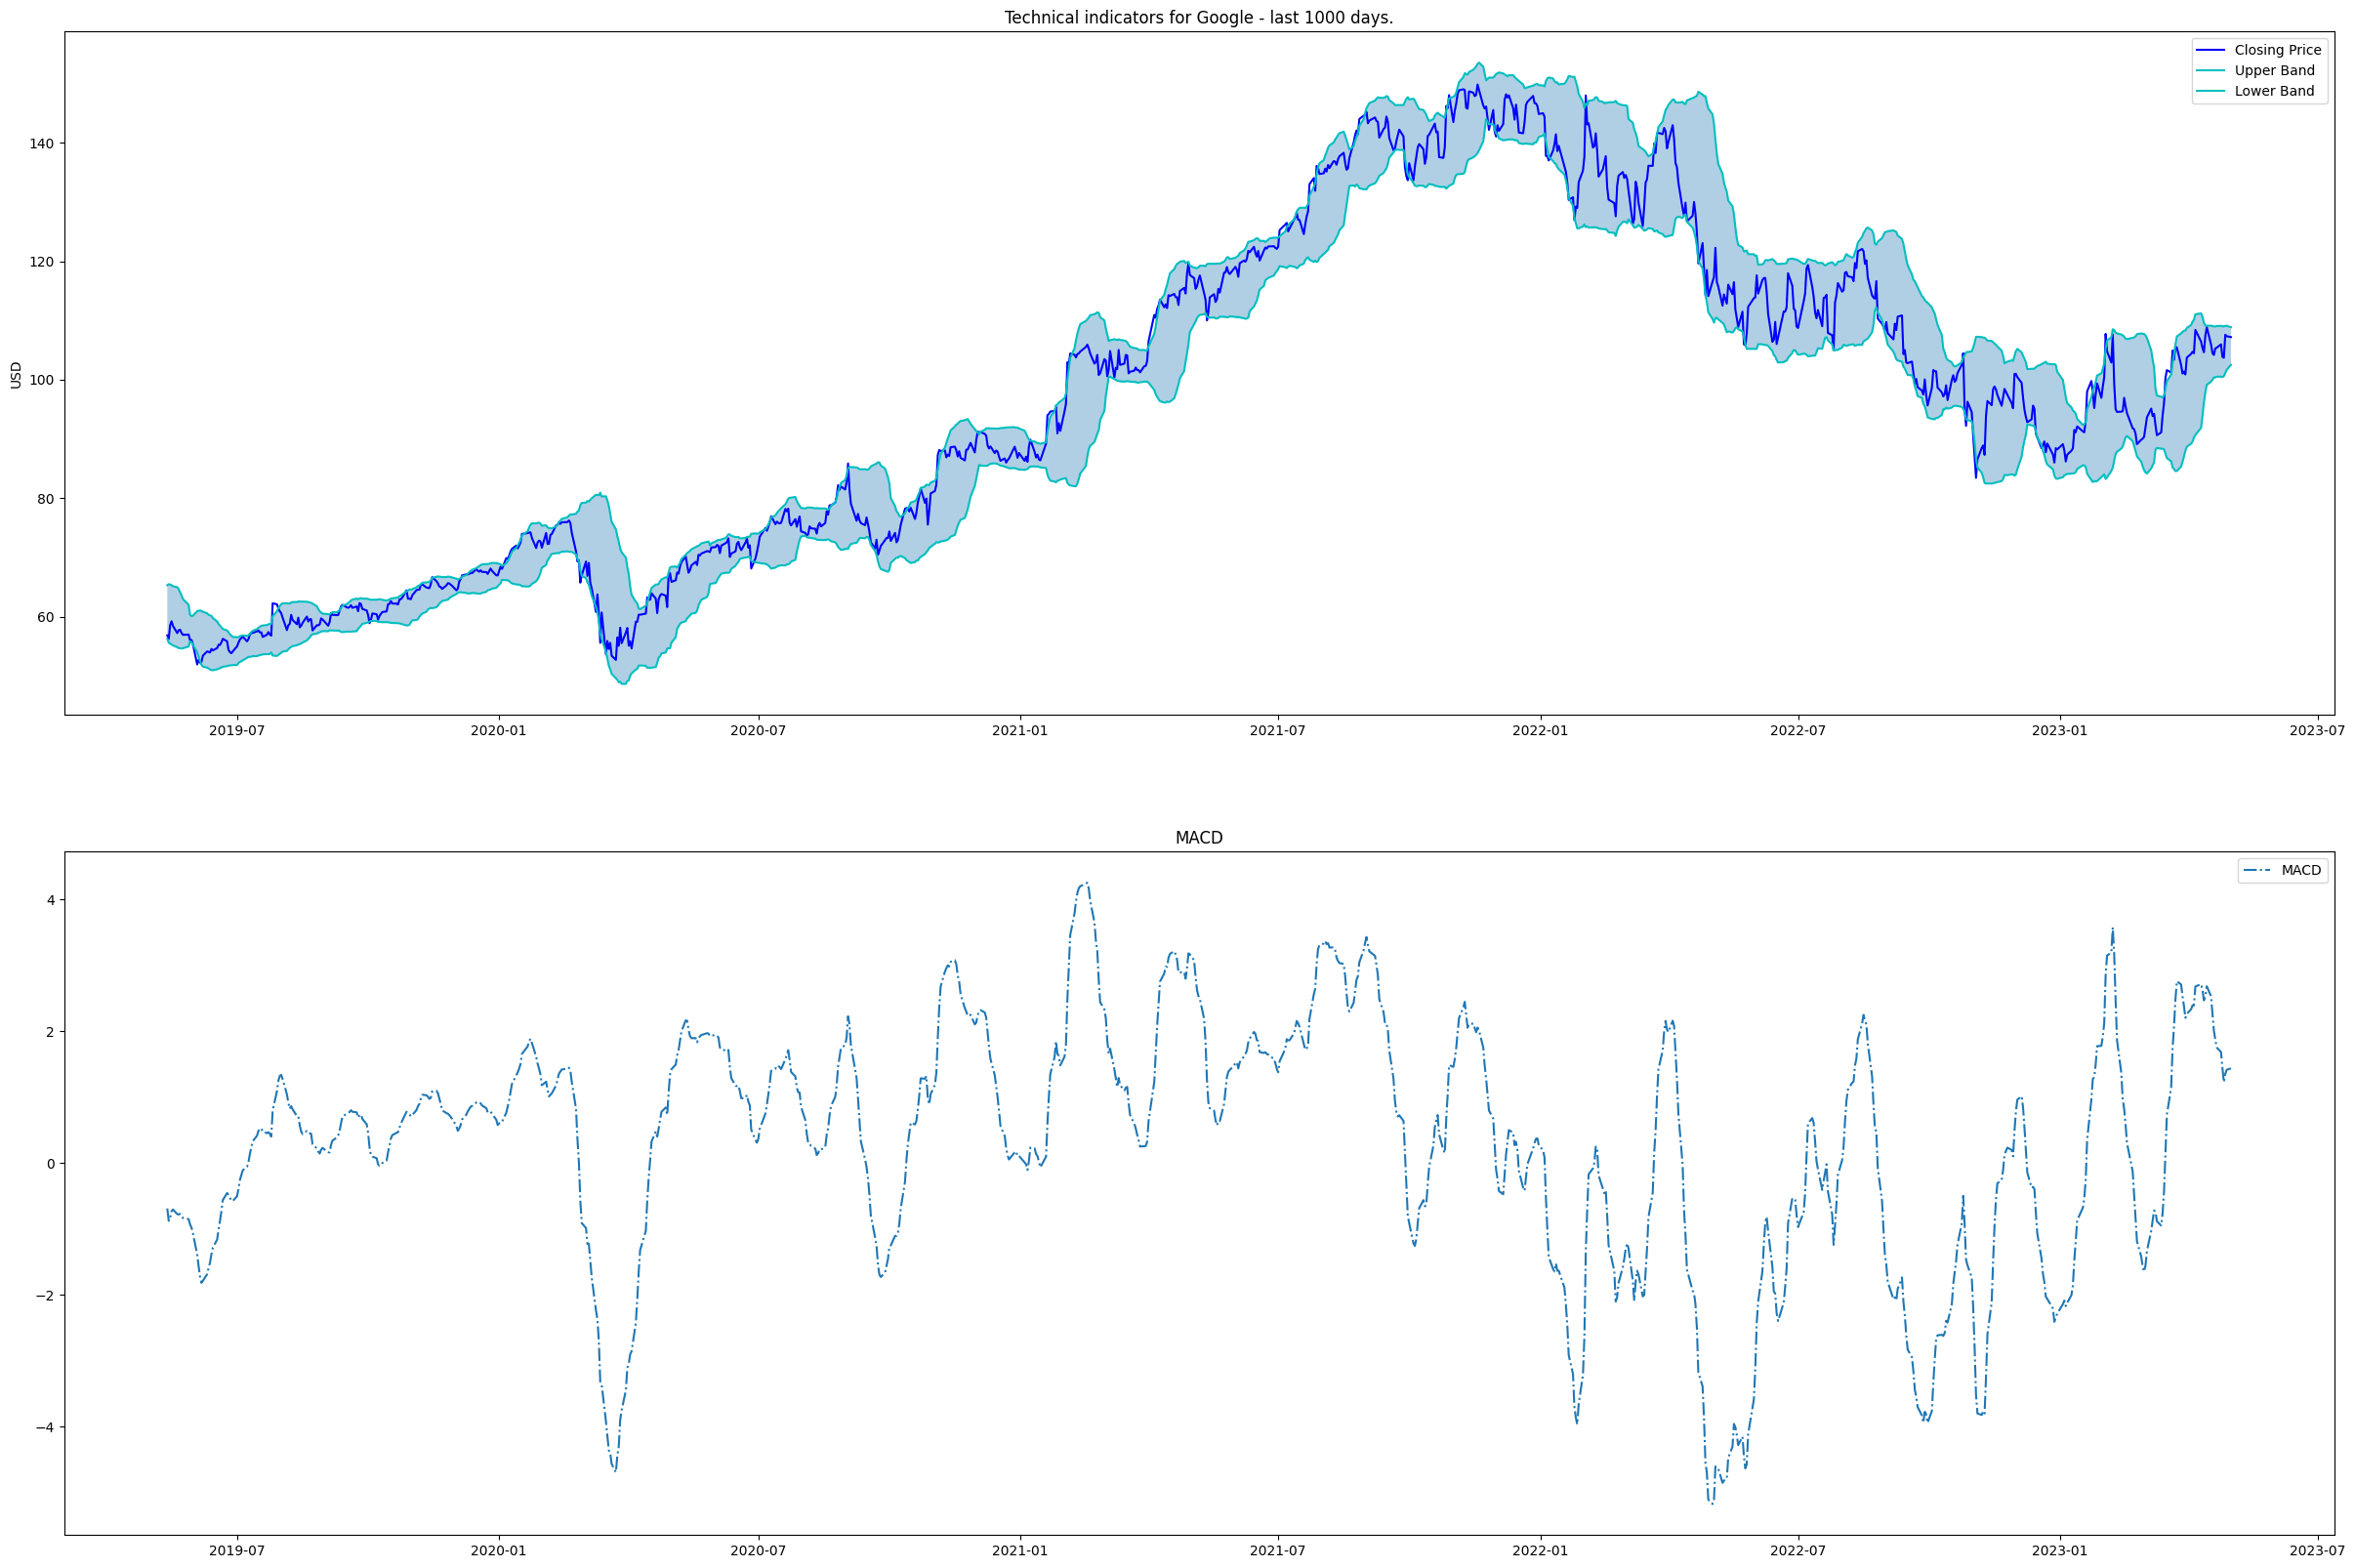

In [ ]:
plot_technical_indicators(df_ta, 1000)

In [ ]:
df_ta

,Close,MACD,upper_band,lower_band,ema
Date,,,,,
2015-02-02,26.610001,0.172907,27.236469,24.433007,26.571273
2015-02-03,26.665001,0.189818,27.264847,24.422487,26.633758
2015-02-04,26.305000,0.176225,27.294023,24.424930,26.414586
2015-02-05,26.491501,0.176409,27.353219,24.476162,26.465863
2015-02-06,26.694000,0.188553,27.426978,24.539213,26.617954
...,...,...,...,...,...
2023-04-25,103.849998,1.443277,109.028229,100.435582,104.480613
2023-04-26,103.709999,1.226096,108.989055,100.593804,103.966871
2023-04-27,107.589996,1.351483,109.097172,101.110448,106.382288


In [ ]:
Scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_ta = Scaler.fit_transform(df_ta)

training_data_len = int(np.ceil( len(df_ta) * .80 ))

train_data_ta = scaled_data_ta[0:training_data_len, :]


In [ ]:
X_train = []
y_train = []
for i in range(feature_length, train_data_ta.shape[0]):
    X_train.append(train_data_ta[i-feature_length: i])
    y_train.append(train_data_ta[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5 ))
X_train.shape

(1561, 100, 5)

In [ ]:
training_data_len

1661

In [ ]:
#Model
model2 = Sequential([
    LSTM(100, return_sequences=True,  activation = 'relu', input_shape = (X_train.shape[1],5)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),

    Dense(1),
])
model2.compile(optimizer = "adam", loss = "mean_squared_error")
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 100)          42400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 1
)

Epoch 1/100
131/131 [==============================] - 34s 225ms/step - loss: 0.0057
Epoch 2/100
131/131 [==============================] - 30s 229ms/step - loss: 0.0021
Epoch 3/100
131/131 [==============================] - 30s 225ms/step - loss: 0.0014
Epoch 4/100
131/131 [==============================] - 29s 220ms/step - loss: 0.0016
Epoch 5/100
131/131 [==============================] - 29s 221ms/step - loss: 0.0012
Epoch 6/100
131/131 [==============================] - 29s 223ms/step - loss: 0.0015
Epoch 7/100
131/131 [==============================] - 29s 219ms/step - loss: 0.0012
Epoch 8/100
131/131 [==============================] - 29s 224ms/step - loss: 0.0010
Epoch 9/100
131/131 [==============================] - 30s 226ms/step - loss: 0.0011
Epoch 10/100
131/131 [==============================] - 29s 220ms/step - loss: 0.0011
Epoch 11/100
131/131 [==============================] - 29s 223ms/step - loss: 9.2975e-04
Epoch 12/100
131/131 [==============================] - 29s

In [ ]:
X_test = []
y_test = []
test_data = scaled_data_ta[training_data_len - feature_length: , :]

for i in range(feature_length, test_data.shape[0]):
    X_test.append(test_data[i-feature_length:i])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((415, 100, 5), (415,))

In [ ]:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5 ))
# Get the models predicted price values
predictions = model2.predict(X_test)


13/13 [==============================] - 1s 32ms/step


In [ ]:

predictions = Scaler.inverse_transform(predictions)


In [ ]:
scale = 1/Scaler.scale_[0]
y_pred = predictions*scale
y_test = y_test*scale
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
error = mean_absolute_percentage_error(y_test, y_pred)
print(error)

92.16901833053673
0.04242957081974163


<ipython-input-37-dd7a722f8272>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = y_pred


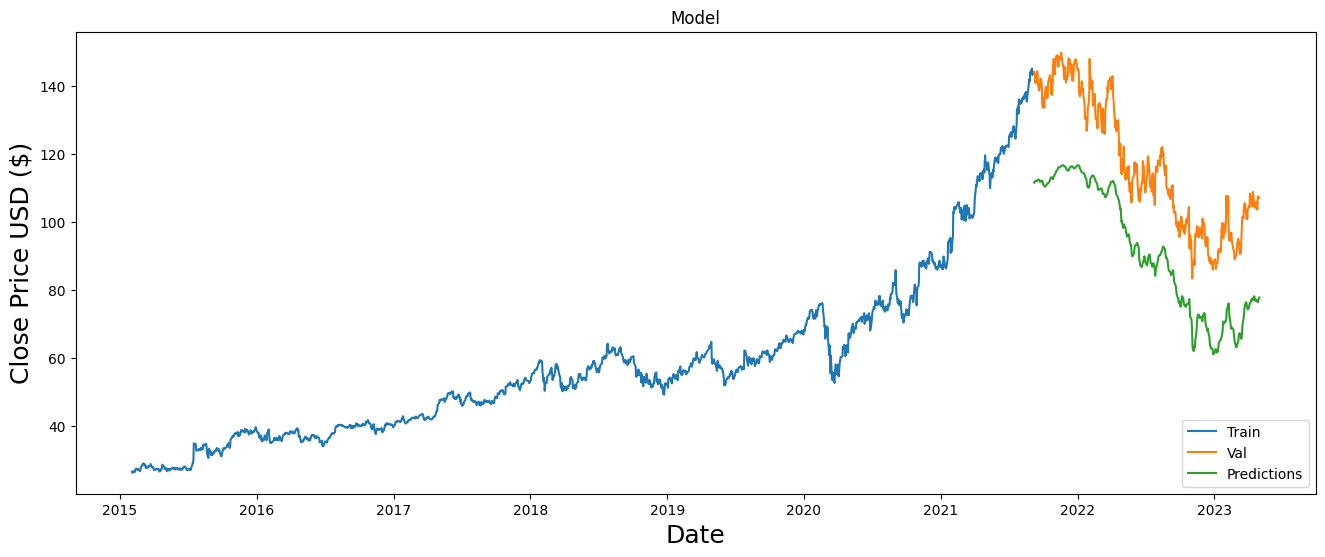

In [ ]:
# Plot the data
train2 = df_ta[:training_data_len]
valid2 = df_ta[training_data_len:]
valid2['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train2['Close'])
plt.plot(valid2[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid2

,Close,MACD,upper_band,lower_band,ema,Predictions
Date,,,,,,
2021-09-07,144.280502,3.143716,147.127165,133.166835,144.112522,111.618462
2021-09-08,143.690994,3.006594,147.448687,133.490837,143.831504,111.853035
2021-09-09,143.541000,2.852933,147.680774,133.900083,143.637835,112.043762
2021-09-10,140.876007,2.487440,147.582497,134.436170,141.796616,112.183159
2021-09-13,142.332504,2.288926,147.609637,134.898411,142.153875,112.137077
...,...,...,...,...,...,...
2023-04-25,103.849998,1.443277,109.028229,100.435582,104.480613,77.145264
2023-04-26,103.709999,1.226096,108.989055,100.593804,103.966871,76.811607
2023-04-27,107.589996,1.351483,109.097172,101.110448,106.382288,76.423744


In [ ]:
input_signature = [tf.TensorSpec([None, 100, 5], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model2, input_signature, opset=13)
onnx.save(onnx_model, "model2.onnx")

In [ ]:
new_data_close = new_data.filter(['Close'])

new_data_ta = get_technical_indicators(new_data_close)
new_data_ta = new_data_ta.dropna()
new_data_ta.head()

,Close,MACD,upper_band,lower_band,ema
Date,,,,,
2023-05-31,122.870003,2.155805,131.603687,101.494410,123.176479
2023-06-01,123.720001,2.105177,131.864213,102.986265,123.538827
2023-06-02,124.669998,2.105496,132.001637,104.683126,124.292941
2023-06-05,126.010002,2.173013,131.876696,106.838543,125.437648
2023-06-06,127.309998,2.290323,131.655825,109.129890,126.685881


In [ ]:
def predict_given_date2(model,data,date, feature_length):
  if date not in data.index:
    data.loc[pd.Timestamp(date)] = 0
  idx = data.index.get_loc(date)
  data = data.iloc[idx-feature_length : idx, :].values
  data = np.expand_dims(Scaler.transform(data), axis = 0)
  Prediction = model.predict(data)
  scale = 1/Scaler.scale_[0]
  Prediction = Prediction*scale

  return Prediction

predict_given_date2(model2,new_data_ta, "2023-06-06", feature_length)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 503ms/step


array([[85.9828]], dtype=float32)

In [ ]:
def predict_given_date_with_onnx2(model,data, date, feature_length):
    if date not in data.index:
        data.loc[pd.Timestamp(date)] = 0
    idx = data.index.get_loc(date)
    data = data.iloc[idx - feature_length:idx, :].values
    data = Scaler.transform(data)

    # Pad or trim the input to match the expected shape
    input_data = np.zeros((1, 100, 5), dtype=np.float32)
    if data.shape[0] >= 100:
        input_data[:] = data[-100:,]
    else:
        input_data[0,-data.shape[0]:, ] = data[:,:]

    # Load the ONNX model
    onnx_model = model
    session = ort.InferenceSession(onnx_model.SerializeToString())

    # Run prediction using the ONNX model
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    prediction = session.run([output_name], {input_name: input_data})[0]
    scale = 1/Scaler.scale_[0]
    prediction = prediction*scale


    return prediction

onnx_model = onnx.load("model2.onnx")
predict_given_date_with_onnx2(onnx_model,new_data_ta, "2023-06-06", feature_length)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[82.912056]], dtype=float32)

In [ ]:
new_data_ta

,Close,MACD,upper_band,lower_band,ema
Date,,,,,
2023-05-31,122.870003,2.155805,131.603687,101.494410,123.176479
2023-06-01,123.720001,2.105177,131.864213,102.986265,123.538827
2023-06-02,124.669998,2.105496,132.001637,104.683126,124.292941
2023-06-05,126.010002,2.173013,131.876696,106.838543,125.437648
2023-06-06,127.309998,2.290323,131.655825,109.129890,126.685881
2023-06-07,122.500000,2.017061,130.779776,111.408797,123.895294
2023-06-08,122.139999,1.755064,129.158127,114.439017,122.725098
2023-06-09,122.230003,1.536756,128.038657,116.556582,122.395035
2023-06-12,123.639999,1.450196,127.760955,117.507618,123.225011


# WITH Sentiment Analysis

In [ ]:
spark = sparknlp.start()

In [ ]:
import pandas as pd
data = pd.read_csv("/kaggle/input/projects2/news_EOD_google.csv")
data = data[["Date", "Title", "Content"]]
data.head()

,Date,Title,Content
0,2023-06-20T21:45:22+00:00,Alphabet Inc. (GOOG) Stock Moves -0.17%: What ...,Alphabet Inc. (GOOG) closed at $123.85 in the ...
1,2023-06-20T21:45:18+00:00,"Warren Buffett's Berkshire Could Join Apple, M...",The Oracle of Omaha is marching his investment...
2,2023-06-20T21:24:10+00:00,UPDATE 2-EU singles out 19 tech giants for onl...,"(Adds details on Meta, Twitter, TikTok)\n\nBy ..."
3,2023-06-20T20:40:00+00:00,1 Obvious Reason Alphabet Should Spin Off YouTube,"Ask most quality-focused investors out there, ..."
4,2023-06-20T20:07:57+00:00,"AmazonFresh, Instacart, and More: The Best Gro...",©Instacart\n\nGrocery and meal delivery servic...


In [ ]:
from pyspark.sql import functions as F

df = spark.createDataFrame(data)

# Concaténer les colonnes 'Title' et 'Content' en utilisant une UDF
concat_udf = F.udf(lambda title, content: title + '. ' + content, StringType())
df = df.withColumn('News', concat_udf(df['Title'], df['Content']))

# Sélectionner les colonnes 'Date' et 'News'
df = df.select('Date', 'News')

# Convertir la colonne 'Date' au format datetime
df = df.withColumn('Date', F.to_date(df['Date']).alias('Date'))

# Grouper les données
df = df.groupby('Date').agg(F.collect_list('News').alias('News'))

df.show()


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/06/30 15:34:45 WARN TaskSetManager: Stage 0 contains a task of very large size (17307 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+
|      Date|                News|
+----------+--------------------+
|2021-09-21|[Wall Street Clos...|
|2021-09-24|[Google Cloud Gai...|
|2021-09-25|[Google, Nike, Ap...|
|2021-09-26|[Waymo hired a di...|
|2021-09-28|[Alphabet (GOOGL)...|
|2021-09-29|[7 Stocks To Watc...|
|2021-09-30|[Google earnings ...|
|2021-10-02|[YouTube, TikTok ...|
|2021-10-03|[EU tech rules sh...|
|2021-10-05|[Daily Mail publi...|
|2021-10-06|[Tencent's WeChat...|
|2021-10-08|[UK should legisl...|
|2021-10-11|[Tech Earnings Ar...|
|2021-10-16|[The Safest Stock...|
|2021-10-17|[Is Alphabet (GOO...|
|2021-10-18|[Iranian Hackers ...|
|2021-10-20|[Google Is (Still...|
|2021-10-21|[Google rivals wa...|
|2021-10-22|[Ex-Google Engine...|
|2021-10-23|[George Soros Sto...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
df.printSchema()

In [ ]:
# Ajouter une colonne "News_Length" avec la longueur de chaque liste dans la colonne "News"
df = df.withColumn("News_Length", F.size(df["News"]))

df.show()

23/06/30 15:35:23 WARN TaskSetManager: Stage 3 contains a task of very large size (17307 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-----------+
|      Date|                News|News_Length|
+----------+--------------------+-----------+
|2021-09-21|[Wall Street Clos...|         29|
|2021-09-24|[Google Cloud Gai...|         15|
|2021-09-25|[Google, Nike, Ap...|          4|
|2021-09-26|[Waymo hired a di...|          6|
|2021-09-28|[Alphabet (GOOGL)...|         24|
|2021-09-29|[7 Stocks To Watc...|         34|
|2021-09-30|[Google earnings ...|         21|
|2021-10-02|[YouTube, TikTok ...|         12|
|2021-10-03|[EU tech rules sh...|          4|
|2021-10-05|[Daily Mail publi...|         32|
|2021-10-06|[Tencent's WeChat...|         26|
|2021-10-08|[UK should legisl...|         22|
|2021-10-11|[Tech Earnings Ar...|         14|
|2021-10-16|[The Safest Stock...|          5|
|2021-10-17|[Is Alphabet (GOO...|          4|
|2021-10-18|[Iranian Hackers ...|         18|
|2021-10-20|[Google Is (Still...|         26|
|2021-10-21|[Google rivals wa...|         48|
|2021-10-22|[Ex-Google Engine...| 

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Define a UDF to truncate the list to a maximum of 5 elements
truncate_list_udf = udf(lambda x: x[:5], ArrayType(StringType()))

# Apply the UDF to the "News" column and create a new column "Truncated_News"
df = df.withColumn("Truncated_News", truncate_list_udf(df["News"]))

# Calculate the length of the truncated news
df = df.withColumn("Truncated_News_Length", F.size(df["Truncated_News"]))
df = df.withColumn("News_Length", F.size(df["News"]))

# Show the DataFrame with the truncated news and their lengths
df.show()


23/06/30 15:35:39 WARN TaskSetManager: Stage 6 contains a task of very large size (17307 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-----------+--------------------+---------------------+
|      Date|                News|News_Length|      Truncated_News|Truncated_News_Length|
+----------+--------------------+-----------+--------------------+---------------------+
|2021-09-21|[Wall Street Clos...|         29|[Wall Street Clos...|                    5|
|2021-09-24|[Google Cloud Gai...|         15|[Google Cloud Gai...|                    5|
|2021-09-25|[Google, Nike, Ap...|          4|[Google, Nike, Ap...|                    4|
|2021-09-26|[Waymo hired a di...|          6|[Waymo hired a di...|                    5|
|2021-09-28|[Alphabet (GOOGL)...|         24|[Alphabet (GOOGL)...|                    5|
|2021-09-29|[7 Stocks To Watc...|         34|[7 Stocks To Watc...|                    5|
|2021-09-30|[Google earnings ...|         21|[Google earnings ...|                    5|
|2021-10-02|[YouTube, TikTok ...|         12|[YouTube, TikTok ...|                    5|
|2021-10-03|[EU tech 

# Faut pas executer ceci

In [ ]:
document = DocumentAssembler()\
    .setInputCol("Sentence")\
    .setOutputCol("document")

embeddings = BertSentenceEmbeddings\
    .pretrained('sent_bert_wiki_books_sst2', 'en') \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

sentimentClassifier = ClassifierDLModel.pretrained("classifierdl_bertwiki_finance_sentiment", "en") \
  .setInputCols(["sentence_embeddings"]) \
  .setOutputCol("Sentiment")

finisher = Finisher() \
      .setInputCols(["Sentiment"]) \
      .setOutputCols("final_sentiment") \
      .setOutputAsArray(True)

financial_sentiment_pipeline = Pipeline(
    stages=[document,
            embeddings,
            sentimentClassifier,
            finisher
            ])

sent_bert_wiki_books_sst2 download started this may take some time.

Approximate size to download 389.7 MB

[OK!]

classifierdl_bertwiki_finance_sentiment download started this may take some time.

Approximate size to download 22.5 MB

[OK!]


# Ceci non plus

In [ ]:
from pyspark.sql import SparkSession

def sentiment_analyst(lst):
    # Création d'un DataFrame à partir de la liste
    df = spark.createDataFrame([(sentence,) for sentence in lst], ["Sentence"])
    result = financial_sentiment_pipeline.fit(df).transform(df)
    total_count = result.count()

    r = result.select("final_sentiment").toPandas()
    r['final_sentiment'] = r['final_sentiment'].apply(lambda x: ''.join(x))
    # Compter le nombre d'occurrences de chaque sentiment
    #print(r.head())
    sentiment_counts = r['final_sentiment'].value_counts()
    count_neg = sentiment_counts.get("negative", 0)
    count_pos = sentiment_counts.get("positive", 0)
    count_neu = sentiment_counts.get("neutral", 0)

    return count_pos/total_count,count_neu/total_count,count_neg/total_count


# Ceci non plus

In [ ]:
import pandas as pd

def process_sentiments(df):
    # Création d'une liste pour stocker les résultats
    results = []

    # Parcours des lignes du DataFrame
    for row in df.rdd.collect():
        date = row.Date
        news_list = row.Truncated_News

        # Appel de la fonction sentiment_analyst
        sentiment_ratios = sentiment_analyst(news_list)

        # Ajout des résultats à la liste
        results.append([date, *sentiment_ratios])

    # Création du DataFrame Pandas
    columns = ["Date", "RatioPos", "RatioNeu", "RatioNeg"]
    result_df = pd.DataFrame(results, columns=columns)

    return result_df

# La tu peux commencer a executer a nouveau

In [ ]:
#ratio_df = process_sentiments(df)
#ratio_df.to_csv("ratio_sa.csv",index = False)
ratio_df = pd.read_csv("ratio_sa.csv")
ratio_df.head()

,Date,RatioPos,RatioNeu,RatioNeg
0,2021-09-21,0.6,0.4,0.0
1,2021-09-24,0.2,0.6,0.2
2,2021-09-25,0.0,1.0,0.0
3,2021-09-26,0.2,0.8,0.0
4,2021-09-28,0.6,0.4,0.0


In [ ]:
ratio_df.shape

(635, 4)

In [ ]:
import pandas as pd

# Convertir le type de données de la colonne de date dans ratio_df en datetime64[ns]
ratio_df['Date'] = pd.to_datetime(ratio_df['Date'])

# Compléter df_ta avec les colonnes de ratio_df en fonction de la correspondance des dates
df_ta_sa = pd.merge(df_ta, ratio_df, on='Date', how='left')

# Remplacer les valeurs manquantes par 0 dans les nouvelles colonnes
df_ta_sa[['RatioPos', 'RatioNeu', 'RatioNeg']] = df_ta_sa[['RatioPos', 'RatioNeu', 'RatioNeg']].fillna(0)
df_ta_sa.set_index("Date",inplace=True)


In [ ]:
df_ta_sa

,Close,MACD,upper_band,lower_band,ema,RatioPos,RatioNeu,RatioNeg
Date,,,,,,,,
2015-02-02,26.610001,0.172907,27.236469,24.433007,26.571273,0.0,0.0,0.0
2015-02-03,26.665001,0.189818,27.264847,24.422487,26.633758,0.0,0.0,0.0
2015-02-04,26.305000,0.176225,27.294023,24.424930,26.414586,0.0,0.0,0.0
2015-02-05,26.491501,0.176409,27.353219,24.476162,26.465863,0.0,0.0,0.0
2015-02-06,26.694000,0.188553,27.426978,24.539213,26.617954,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-04-25,103.849998,1.443277,109.028229,100.435582,104.480613,0.0,1.0,0.0
2023-04-26,103.709999,1.226096,108.989055,100.593804,103.966871,0.2,0.6,0.2
2023-04-27,107.589996,1.351483,109.097172,101.110448,106.382288,0.4,0.6,0.0


In [ ]:
Scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_ta = Scaler.fit_transform(df_ta_sa)

training_data_len = int(np.ceil( len(df_ta_sa) * .80 ))

train_data_ta = scaled_data_ta[0:training_data_len, :]


In [ ]:
X_train = []
y_train = []
feature_length = 100
for i in range(feature_length, train_data_ta.shape[0]):
    X_train.append(train_data_ta[i-feature_length: i])
    y_train.append(train_data_ta[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(1561, 100, 8)

In [ ]:
train_data_ta.shape

(1661, 8)

In [ ]:
#Model3
model3 = Sequential([
    LSTM(100, return_sequences=True,  activation = 'relu', input_shape = (X_train.shape[1],8)),
    Dropout(0.5),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1),
])
model3.compile(optimizer = "adam", loss = "mean_squared_error")
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          43600     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 124,101
Trainable params: 124,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model3.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 1
)

Epoch 1/100
131/131 [==============================] - 25s 152ms/step - loss: 0.0050
Epoch 2/100
131/131 [==============================] - 19s 148ms/step - loss: 0.0018
Epoch 3/100
131/131 [==============================] - 21s 160ms/step - loss: 0.0019
Epoch 4/100
131/131 [==============================] - 19s 148ms/step - loss: 0.0018
Epoch 5/100
131/131 [==============================] - 20s 155ms/step - loss: 0.0015
Epoch 6/100
131/131 [==============================] - 20s 152ms/step - loss: 0.0015
Epoch 7/100
131/131 [==============================] - 19s 148ms/step - loss: 0.0013
Epoch 8/100
131/131 [==============================] - 21s 160ms/step - loss: 0.0010
Epoch 9/100
131/131 [==============================] - 19s 147ms/step - loss: 0.0011
Epoch 10/100
131/131 [==============================] - 20s 154ms/step - loss: 0.0013
Epoch 11/100
131/131 [==============================] - 20s 153ms/step - loss: 0.0012
Epoch 12/100
131/131 [==============================] - 19s 148

In [ ]:
X_test = []
y_test = []
test_data = scaled_data_ta[training_data_len - feature_length: , :]

for i in range(feature_length, test_data.shape[0]):
    X_test.append(test_data[i-feature_length:i])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((415, 100, 8), (415,))

In [ ]:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 8))
# Get the models predicted price values
predictions = model3.predict(X_test)


13/13 [==============================] - 1s 57ms/step


In [ ]:
scale = 1/Scaler.scale_[0]
y_pred = predictions*scale
y_test = y_test*scale
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
error = mean_absolute_percentage_error(y_test, y_pred)
print(error)

92.12911034116986
0.09046683743590304


<ipython-input-33-6a396c43cec9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid3['Predictions'] = y_pred


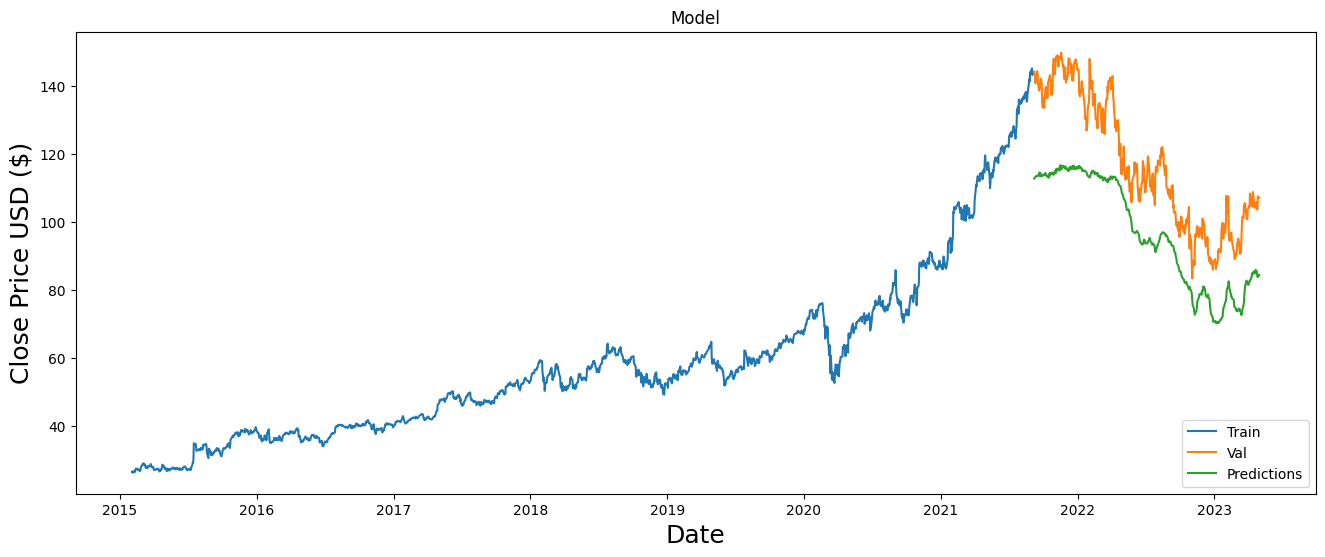

In [ ]:
# Plot the data
train3 = df_ta_sa[:training_data_len]
valid3 = df_ta_sa[training_data_len:]
valid3['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train3['Close'])
plt.plot(valid3[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid3

,Close,MACD,upper_band,lower_band,ema,RatioPos,RatioNeu,RatioNeg,Predictions
Date,,,,,,,,,
2021-09-07,144.280502,3.143716,147.127165,133.166835,144.112522,0.0,0.0,0.0,112.815727
2021-09-08,143.690994,3.006594,147.448687,133.490837,143.831504,0.0,0.0,0.0,113.001755
2021-09-09,143.541000,2.852933,147.680774,133.900083,143.637835,0.0,0.0,0.0,113.212738
2021-09-10,140.876007,2.487440,147.582497,134.436170,141.796616,0.0,0.0,0.0,113.352478
2021-09-13,142.332504,2.288926,147.609637,134.898411,142.153875,0.0,0.0,0.0,113.593765
...,...,...,...,...,...,...,...,...,...
2023-04-25,103.849998,1.443277,109.028229,100.435582,104.480613,0.0,1.0,0.0,84.781265
2023-04-26,103.709999,1.226096,108.989055,100.593804,103.966871,0.2,0.6,0.2,84.082504
2023-04-27,107.589996,1.351483,109.097172,101.110448,106.382288,0.4,0.6,0.0,83.809135


In [ ]:
input_signature = [tf.TensorSpec([None, 100, 8], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model3, input_signature, opset=13)
onnx.save(onnx_model, "model3.onnx")

In [ ]:
df_sa = df_ta_sa[["Close","RatioPos","RatioNeu","RatioNeg"]]
df_sa.head()

,Close,RatioPos,RatioNeu,RatioNeg
Date,,,,
2015-02-02,26.610001,0.0,0.0,0.0
2015-02-03,26.665001,0.0,0.0,0.0
2015-02-04,26.305000,0.0,0.0,0.0
2015-02-05,26.491501,0.0,0.0,0.0
2015-02-06,26.694000,0.0,0.0,0.0


In [ ]:
def predict_given_date(model,data,date, feature_length):
  if date not in data.index:
    data.loc[pd.Timestamp(date)] = 0
  idx = data.index.get_loc(date)
  data = data.iloc[idx-feature_length : idx, :].values
  data = np.expand_dims(Scaler.transform(data), axis = 0)
  Prediction = model.predict(data)
  scale = 1/Scaler.scale_[0]
  Prediction = Prediction*scale

  return Prediction

predict_given_date(model3,df_sa, "2023-05-01", feature_length)

In [ ]:
def predict_given_date_with_onnx2(model,data, date, feature_length):
    if date not in data.index:
        data.loc[pd.Timestamp(date)] = 0
    idx = data.index.get_loc(date)
    data = data.iloc[idx - feature_length:idx, :].values
    data = Scaler.transform(data)

    # Pad or trim the input to match the expected shape
    input_data = np.zeros((1, 100, 4), dtype=np.float32)
    if data.shape[0] >= 100:
        input_data[:] = data[-100:,]
    else:
        input_data[0,-data.shape[0]:, ] = data[:,:]

    # Load the ONNX model
    onnx_model = model
    session = ort.InferenceSession(onnx_model.SerializeToString())

    # Run prediction using the ONNX model
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    prediction = session.run([output_name], {input_name: input_data})[0]
    scale = 1/Scaler.scale_[0]
    prediction = prediction*scale


    return prediction

onnx_model = onnx.load("model4.onnx")
predict_given_date_with_onnx2(onnx_model,df_sa, "2023-06-06", feature_length)

In [ ]:
Scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_sa = Scaler.fit_transform(df_sa)

training_data_len = int(np.ceil( len(df_sa) * .80 ))

train_data_sa = scaled_data_sa[0:training_data_len, :]


In [ ]:
X_train = []
y_train = []
feature_length = 100
for i in range(feature_length, train_data_sa.shape[0]):
    X_train.append(train_data_sa[i-feature_length: i])
    y_train.append(train_data_sa[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#Model4
model4 = Sequential([
    LSTM(100, return_sequences=True,  activation = 'relu', input_shape = (X_train.shape[1],4)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1),
])
model4.compile(optimizer = "adam", loss = "mean_squared_error")
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100, 100)          42000     
                                                                 
 dropout_10 (Dropout)        (None, 100, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 122,501
Trainable params: 122,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 1
)

Epoch 1/100
131/131 [==============================] - 39s 265ms/step - loss: 0.0055
Epoch 2/100
131/131 [==============================] - 28s 217ms/step - loss: 0.0016
Epoch 3/100
131/131 [==============================] - 28s 216ms/step - loss: 0.0016
Epoch 4/100
131/131 [==============================] - 30s 229ms/step - loss: 0.0013
Epoch 5/100
131/131 [==============================] - 28s 215ms/step - loss: 9.7744e-04
Epoch 6/100
131/131 [==============================] - 29s 221ms/step - loss: 0.0011
Epoch 7/100
131/131 [==============================] - 28s 216ms/step - loss: 0.0011
Epoch 8/100
131/131 [==============================] - 28s 216ms/step - loss: 0.0011
Epoch 9/100
131/131 [==============================] - 28s 215ms/step - loss: 9.3319e-04
Epoch 10/100
131/131 [==============================] - 28s 214ms/step - loss: 0.0011
Epoch 11/100
131/131 [==============================] - 28s 213ms/step - loss: 0.0012
Epoch 12/100
131/131 [==============================] -

In [ ]:
X_test = []
y_test = []
test_data = scaled_data_sa[training_data_len - feature_length: , :]

for i in range(feature_length, test_data.shape[0]):
    X_test.append(test_data[i-feature_length:i])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape



((415, 100, 4), (415,))

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
# Get the models predicted price values
predictions = model4.predict(X_test)

13/13 [==============================] - 1s 28ms/step


In [ ]:
scale = 1/Scaler.scale_[0]
y_pred = predictions*scale
y_test = y_test*scale
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)
error = mean_absolute_percentage_error(y_test, y_pred)
print(error)

11474.972107751686
0.9912834937091826


/tmp/ipykernel_29/1678884920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid4['Predictions'] = y_pred


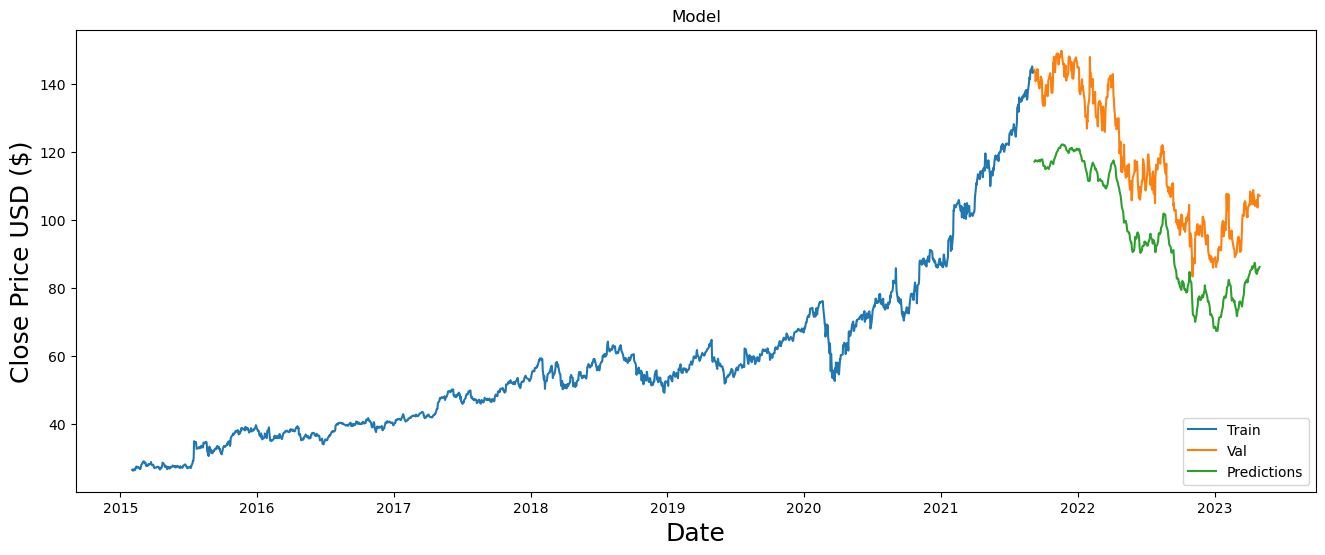

In [ ]:
# Plot the data
train4 = df_sa[:training_data_len]
valid4 = df_sa[training_data_len:]
valid4['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train4['Close'])
plt.plot(valid4[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid4

,Close,RatioPos,RatioNeu,RatioNeg,Predictions
Date,,,,,
2021-09-07,144.280502,0.0,0.0,0.0,117.217300
2021-09-08,143.690994,0.0,0.0,0.0,117.411957
2021-09-09,143.541000,0.0,0.0,0.0,117.558853
2021-09-10,140.876007,0.0,0.0,0.0,117.644775
2021-09-13,142.332504,0.0,0.0,0.0,117.387344
...,...,...,...,...,...
2023-04-25,103.849998,0.0,1.0,0.0,84.650070
2023-04-26,103.709999,0.2,0.6,0.2,85.514091
2023-04-27,107.589996,0.4,0.6,0.0,85.279152


In [ ]:
input_signature = [tf.TensorSpec([None, 100, 4], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model4, input_signature, opset=17)
onnx.save(onnx_model, "model4.onnx")

In [ ]:
def predict_given_date(model,data,date, feature_length):
  if date not in data.index:
    data.loc[pd.Timestamp(date)] = 0
  idx = data.index.get_loc(date)
  data = data.iloc[idx-feature_length : idx, :].values
  data = np.expand_dims(Scaler.transform(data), axis = 0)
  Prediction = model.predict(data)
  scale = 1/Scaler.scale_[0]
  Prediction = Prediction*scale

  return Prediction

predict_given_date(model4,df_sa, "2023-05-01", feature_length)

1/1 [==============================] - 0s 41ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[86.23142]], dtype=float32)

In [ ]:
def predict_given_date_with_onnx2(model,data, date, feature_length):
    if date not in data.index:
        data.loc[pd.Timestamp(date)] = 0
    idx = data.index.get_loc(date)
    data = data.iloc[idx - feature_length:idx, :].values
    data = Scaler.transform(data)

    # Pad or trim the input to match the expected shape
    input_data = np.zeros((1, 100, 4), dtype=np.float32)
    if data.shape[0] >= 100:
        input_data[:] = data[-100:,]
    else:
        input_data[0,-data.shape[0]:, ] = data[:,:]

    # Load the ONNX model
    onnx_model = model
    session = ort.InferenceSession(onnx_model.SerializeToString())

    # Run prediction using the ONNX model
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    prediction = session.run([output_name], {input_name: input_data})[0]
    scale = 1/Scaler.scale_[0]
    prediction = prediction*scale


    return prediction

onnx_model = onnx.load("model4.onnx")
predict_given_date_with_onnx2(onnx_model,df_sa, "2023-06-06", feature_length)

/tmp/ipykernel_29/925898807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[pd.Timestamp(date)] = 0
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[86.4579]], dtype=float32)